# Run and Analyse dN/dS (BUSTED output)

## Run HyPhy

```bash
# Run HyPhy in Parallel

# Run BUSTED all whole tree
nohup ~/mambaforge/envs/hgt_analyses/bin/python code/run_hyphy_parallel.py -i data/inferences/dn_ds/map.aln_treefile_input_filepaths.tsv  -o data/inferences/dn_ds/busted/output_all/ -a busted 2>&1 > data/nohup_busted_all_dnds.log & disown

# Run BUSTED with branches with ecosystem gains as foreground
nohup ~/mambaforge/envs/hgt_analyses/bin/python code/run_hyphy_parallel.py -i data/inferences/dn_ds/map.aln_treefile_input_filepaths.fg.tsv  -o data/inferences/dn_ds/busted/output_fg/ -a busted -r2 2>&1 > data/nohup_busted_fg_dnds.log & disown



## Analyse HyPhy output

In [1]:
import os
import sys
import json
import importlib
from scipy.stats import chi2
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')


# Add the code directory to the path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'code'))

# Reload the module to ensure any changes are reflected
if 'analyse_hyphy_output' in sys.modules:
    importlib.reload(sys.modules['analyse_hyphy_output'])
else:
    import analyse_hyphy_output as aho

data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')
plots_dir = os.path.join(data_dir, 'plots')
dnds_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'inferences', 'dn_ds')
busted_dir = os.path.join(dnds_dir, 'busted')
relax_dir = os.path.join(dnds_dir, 'relax')

skipped_ogs_filepath = os.path.join(dnds_dir, 'skipped_tree_ogs.txt')

def get_likelihood_ratio(ll1, ll2):
    return 2 * np.abs(ll1 - ll2)
def get_p_value(ll1, ll2, df=1):
    lr = get_likelihood_ratio(ll1, ll2)
    return chi2.sf(lr, df)


import matplotlib as mpl

plt_style_file = "lib/plot.mplstyle"
plt.style.use(plt_style_file)
mpl.rc_file(plt_style_file)
# Scale the relevant rcParams by 2x
scale_factor = 2
for key in mpl.rcParams:
    try:
        if not "size" in key:
            continue
        if isinstance(mpl.rcParams[key], (int, float)) and not isinstance(
            mpl.rcParams[key], bool
        ):
            mpl.rcParams[key] *= scale_factor
        elif isinstance(mpl.rcParams[key], (list, tuple)):
            mpl.rcParams[key] = [
                (
                    v * scale_factor
                    if isinstance(v, (int, float)) and not isinstance(v, bool)
                    else v
                )
                for v in mpl.rcParams[key]
            ]
    except Exception as e:
        print(f"Error scaling {key} from {mpl.rcParams[key]}: {e}")
        raise e

# update rcparams
# legend box with white background and frame
mpl.rcParams["legend.facecolor"] = "white"
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["legend.edgecolor"] = "black"

In [2]:
def extract_and_process_output(busted_dir, sub_dir, prefix):
    dir_path = os.path.join(busted_dir, sub_dir)
    flat_df = aho.extract_hyphy_output(dir_path, max_threads=2)
    print(f"Number of OGS: {flat_df.shape[0]}")
    # make sure dnds_dir/skipped_tree_ogs.txt ogs are not in the output flat df
    with open(skipped_ogs_filepath, 'r') as f:
        skipped_ogs_list = f.read().splitlines()
    flat_df = flat_df[~flat_df['OG'].isin(skipped_ogs_list)]
    print(f"Number of OGS after filtering for {len(skipped_ogs_list)} skipped ogs: {flat_df.shape[0]}")

    flat_df.to_csv(os.path.join(busted_dir, f'{sub_dir}_out_flat.csv'), index=False)
    flat_df.set_index('OG', inplace=True)
    flat_df.columns = [f'{prefix}|{col}' for col in flat_df.columns]
    return flat_df

def prepare_dfs(busted_dir, sub_dir, prefix):
    busted_flat_df = extract_and_process_output(busted_dir, sub_dir, prefix)
    busted_all_flat_df = extract_and_process_output(busted_dir, 'output_all', 'all')
    # Join the two dataframes on the OG column. This will only keep the OGs that are present in both dataframes
    busted_test_all_df = busted_flat_df.join(busted_all_flat_df, how='inner')
    display(busted_test_all_df)
    busted_test_all_df.to_csv(os.path.join(busted_dir, f'{sub_dir}_all_out_flat.csv'), index=True)

    return busted_test_all_df


# Prepare dataframes
busted_fg_all_df = prepare_dfs(busted_dir, "output_fg", "fg")
# buster_bg_all_df = prepare_dfs(busted_dir, "output_bg", "bg")


Extracting data:   0%|          | 0/2527 [00:00<?, ?it/s]

Extracting data: 100%|██████████| 2527/2527 [01:10<00:00, 35.97it/s]


Error while reading JSON for 0 OGs: []
Exceptions while reading JSON for 0 OGs: {}
Number of OGS: 2527
Number of OGS after filtering for 1115 skipped ogs: 2527


Extracting data: 100%|██████████| 2527/2527 [01:38<00:00, 25.53it/s]


Error while reading JSON for 0 OGs: []
Exceptions while reading JSON for 0 OGs: {}
Number of OGS: 2527
Number of OGS after filtering for 1115 skipped ogs: 2527


,fg|Unconstrained model|AIC-c,fg|Unconstrained model|Log Likelihood,fg|Unconstrained model|estimated parameters,fg|Unconstrained model|Background|0|omega,fg|Unconstrained model|Background|0|proportion,fg|Unconstrained model|Background|1|omega,fg|Unconstrained model|Background|1|proportion,fg|Unconstrained model|Test|0|omega,fg|Unconstrained model|Test|0|proportion,fg|Unconstrained model|Test|1|omega,...,all|Unconstrained model|Test|1|proportion,all|Constrained model|AIC-c,all|Constrained model|Log Likelihood,all|Constrained model|estimated parameters,all|Constrained model|Test|0|omega,all|Constrained model|Test|0|proportion,all|Constrained model|Test|1|omega,all|Constrained model|Test|1|proportion,all|BUSTED-SR test|p-value,all|BUSTED-SR test|LRT
OG,,,,,,,,,,,,,,,,,,,,,
COG5466,2700.643337,-1307.628386,42,0.000000,0.570606,0.043936,0.429394,0.006553,0.563222,0.148733,...,0.540378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.000000
D1CT5,7240.490893,-3573.222257,46,0.000000,0.478036,0.754324,0.472764,0.000000,0.396052,0.154786,...,0.556419,7244.451352,-3581.451726,40.0,0.000000,0.445376,0.196928,0.528018,0.304718,0.990442
D58F0,3453.468172,-1676.234618,48,0.014785,0.390284,0.015041,0.245042,0.023061,0.551127,0.084875,...,0.425950,3445.388444,-1678.787147,42.0,0.027978,0.622556,0.269601,0.377444,0.181017,2.032031
D1JQ0,5403.181471,-2666.513812,34,0.000000,0.887146,0.000000,0.037534,0.000000,0.100323,0.028429,...,0.105623,5393.130725,-2667.834489,28.0,0.032822,0.722776,0.000000,0.104628,0.500000,0.000000
D3Q5G,5239.401800,-2570.401453,48,0.000000,0.856029,0.008382,0.112159,0.000000,0.277188,0.008704,...,0.583337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COG1330,369038.424719,-184355.171412,164,0.007769,0.646807,0.443321,0.344910,0.004166,0.571337,0.101710,...,0.412137,369211.676039,-184447.800006,158.0,0.002970,0.542594,0.092894,0.413606,0.199816,1.834426
COG4401,10764.253530,-5321.804667,60,0.000638,0.790552,0.015741,0.171860,0.000000,0.365702,0.030359,...,0.606775,10765.073096,-5328.275311,54.0,0.000000,0.362627,0.021250,0.596480,0.059955,4.242025
COG5552,6324.343948,-3105.423206,56,0.000571,0.740584,0.024786,0.234608,0.001231,0.483258,0.045679,...,0.362970,6312.280197,-3105.542769,50.0,0.001005,0.593522,0.043978,0.367799,0.116050,2.921174


In [6]:
# Perform a likelihood ratio test, plot histograms, and perform a variance randomisation test
def get_p_value(log_likelihood1, log_likelihood2, df):
    return chi2.sf(2 * (log_likelihood2 - log_likelihood1), df)


def perform_lrt(busted_dir, sub_dir, prefix):
    # Read the combined dataframe of test and all data
    busted_test_all_df = pd.read_csv(
        os.path.join(busted_dir, f"{sub_dir}_all_out_flat.csv")
    )
    busted_test_all_df.set_index("OG", inplace=True)

    # Extract columns related to the unconstrained model
    busted_df_compare_test_all = busted_test_all_df[
        [col for col in busted_test_all_df.columns if "Unconstrained model" in col]
    ].copy()
    busted_df_compare_test_all.index.name = "OG"
    busted_df_compare_test_all.reset_index(inplace=True)

    # Calculate the degrees of freedom for the likelihood ratio test (LRT)
    busted_df_compare_test_all[f"{prefix} all|LRT df"] = np.abs(
        busted_df_compare_test_all[f"{prefix}|Unconstrained model|estimated parameters"]
        - busted_df_compare_test_all["all|Unconstrained model|estimated parameters"]
    )

    # Calculate the p-value for the LRT
    busted_df_compare_test_all[f"{prefix} all|LRT p-value"] = (
        busted_df_compare_test_all.apply(
            lambda row: get_p_value(
                row[f"{prefix}|Unconstrained model|Log Likelihood"],
                row["all|Unconstrained model|Log Likelihood"],
                row[f"{prefix} all|LRT df"],
            ),
            axis=1,
        )
    )

    # Determine if the LRT is significant
    busted_df_compare_test_all[f"{prefix} all|LRT significant"] = (
        busted_df_compare_test_all[f"{prefix} all|LRT p-value"] < 0.05
    )

    # Calculate mean omega values
    omega_columns = [
        col for col in busted_df_compare_test_all.columns if col.endswith("omega")
    ]
    winsorizing_percentile = 95
    for col in omega_columns:
        # # winsorize the data in the omega columns
        # busted_df_compare_test_all[col] = winsorize(
        #     busted_df_compare_test_all[col],
        #     limits=[0, 1 - winsorizing_percentile / 100],
        # )
        # calculate the mean omega values
        busted_df_compare_test_all[col.replace("omega", "mean omega")] = (
            busted_df_compare_test_all[col]
            * busted_df_compare_test_all[col.replace("omega", "proportion")]
        )

    # Calculate weighted mean omega values
    mean_omega_columns = [
        col for col in busted_df_compare_test_all.columns if "mean omega" in col
    ]
    for model_name in [
        f"{prefix}|Unconstrained model|Background|",
        f"{prefix}|Unconstrained model|Test|",
        "all|Unconstrained model|Test|",
    ]:
        find_col = [col for col in mean_omega_columns if col.startswith(model_name)]
        busted_df_compare_test_all[f"{model_name}weighted mean omega"] = (
            busted_df_compare_test_all[find_col].sum(axis=1)
        )

    # Sort the dataframe by weighted mean omega values
    busted_df_compare_test_all.sort_values(
        "all|Unconstrained model|Test|weighted mean omega", inplace=True
    )
    display(busted_df_compare_test_all)

    # Save the results to a CSV file
    busted_df_compare_test_all.to_csv(
        os.path.join(busted_dir, f"{sub_dir}_compare_test_all.csv"), index=False
    )

    return busted_df_compare_test_all


def plot_histograms(busted_dir, sub_dir, prefix, min_proportion=0.0):
    busted_df_compare_test_all = pd.read_csv(os.path.join(busted_dir, f'{sub_dir}_compare_test_all.csv'))

    busted_df_histplot_test_all = busted_df_compare_test_all.copy()

    # background_category = 'Zero ET (Ref)' if prefix == 'fg' else 'Non-zero ET (Ref)'
    # test_category = 'Non-zero ET (Test)' if prefix == 'fg' else 'Zero ET (Test)'
    background_category = 'Zero ET' if prefix == 'fg' else 'Non-zero ET'
    test_category = 'Non-zero ET' if prefix == 'fg' else 'Zero ET'

    if min_proportion > 0:
        # first calculate the proportion of the branch set in the test and background models
        # read in the tsv file with branch counts
        branch_counts_filepath = os.path.join(dnds_dir, 'branch_count.tsv')
        branch_counts_df = pd.read_csv(branch_counts_filepath, sep='\t', header=0)
        # merge the branch counts with the busted_df_histplot_test_all
        busted_df_histplot_test_all = busted_df_histplot_test_all.merge(branch_counts_df, left_on='OG', right_on='nog_id', how='inner')

        # min branch set size
        busted_df_histplot_test_all['min_branch_set_size'] = busted_df_histplot_test_all[['with_transfers', 'without_transfers']].min(axis=1)

        # min branch set proportion
        busted_df_histplot_test_all['min_branch_set_proportion'] = busted_df_histplot_test_all['min_branch_set_size'] / busted_df_histplot_test_all['total']

        # filter out rows where the proportion of the branch set in either the test or background model is less than min_proportion
        busted_df_histplot_test_all = busted_df_histplot_test_all[(busted_df_histplot_test_all['min_branch_set_proportion'] >= min_proportion)]
    display(busted_df_histplot_test_all)

    # print the sizes of each category
    print(f"Total number of OGs in the background category ({background_category}): {busted_df_histplot_test_all[f'{prefix}|Unconstrained model|Background|weighted mean omega'].shape[0]}")
    print(f"Total number of OGs in the test category ({test_category}): {busted_df_histplot_test_all[f'{prefix}|Unconstrained model|Test|weighted mean omega'].shape[0]}")
    print(f"Total number of OGs in the all category: {busted_df_histplot_test_all['all|Unconstrained model|Test|weighted mean omega'].shape[0]}")

    # Create the DataFrame for the histogram
    busted_df_compare_test_all_histplot_df = pd.DataFrame({
        'Weighted Mean Omega': pd.concat([
            busted_df_histplot_test_all[f'{prefix}|Unconstrained model|Background|weighted mean omega'],
            busted_df_histplot_test_all[f'{prefix}|Unconstrained model|Test|weighted mean omega'],
            # busted_df_histplot_test_all['all|Unconstrained model|Test|weighted mean omega']
        ])
    }).reset_index(drop=True)
    display(busted_df_compare_test_all_histplot_df)
    # add a column for the category
    busted_df_compare_test_all_histplot_df['Category'] = pd.concat([
        pd.Series([background_category] * busted_df_histplot_test_all[f'{prefix}|Unconstrained model|Background|weighted mean omega'].shape[0]),
        pd.Series([test_category] * busted_df_histplot_test_all[f'{prefix}|Unconstrained model|Test|weighted mean omega'].shape[0]),
        # pd.Series(['All'] * busted_df_histplot_test_all['all|Unconstrained model|Test|weighted mean omega'].shape[0])
    ]).reset_index(drop=True)
    display(busted_df_compare_test_all_histplot_df)
    # count how many OGs are in each category from the df
    print(busted_df_compare_test_all_histplot_df['Category'].value_counts())

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(data=busted_df_compare_test_all_histplot_df, x='Weighted Mean Omega', hue='Category', 
                #  multiple='stack', 
                 element='step', bins=30, ax=ax, log_scale=(True, False))
    plt.axvline(x=1, color='r', linestyle='--')
    plt.text(1, (max(plt.yticks()[0]) - min(plt.yticks()[0])) * 0.5, r'$\omega = 1$', rotation=90, verticalalignment='center')

    hist_col_names_dict = {
        f'{prefix}|Unconstrained model|Background|weighted mean omega': background_category,
        f'{prefix}|Unconstrained model|Test|weighted mean omega': test_category,
        # 'all|Unconstrained model|Test|weighted mean omega': 'All'
    }
    for col in hist_col_names_dict.keys():
        plt.axvline(x=busted_df_histplot_test_all[col].mean(), linestyle='--',
                    color='black')          
        plt.text(busted_df_histplot_test_all[col].mean(), (max(plt.yticks()[0]) - min(plt.yticks()[0])) * 0.5, f'mean {hist_col_names_dict[col]}', rotation=90, 
                verticalalignment='bottom', 
                horizontalalignment='right',
                fontsize=12)

    plt.xlabel(r'$\omega$')
    plt.ylabel('Frequency')
    #  grid and tight layout
    plt.grid(True)
    plt.tight_layout()

    # plt.title('Histogram of weighted mean omega values')
    # save as png
    png_filepath = os.path.join(plots_dir, f'fg_nonzero_vs_zero_eg_histplot.png')
    plt.savefig(png_filepath)
    plt.show()

    # print means of all categories
    for col in hist_col_names_dict.keys():
        print(f"Mean {hist_col_names_dict[col]}: {busted_df_histplot_test_all[col].mean()}")
        print(f"Median {hist_col_names_dict[col]}: {busted_df_histplot_test_all[col].median()}")
        print(f"Standard deviation {hist_col_names_dict[col]}: {busted_df_histplot_test_all[col].std()}")
        print("-------------------------")

    return busted_df_compare_test_all_histplot_df


# define the function to be run in parallel: this fn will return the var ratio for each iteration and we parallelize across the iterations
def run_vrt_iteration(args):
    # set seed to 314
    np.random.seed(314)

    full_array, num_zero_et = args
    # shuffle the array
    np.random.shuffle(full_array)
    # get the var ratio
    var_ratio = np.var(full_array[:num_zero_et]) / np.var(full_array[num_zero_et:])
    return var_ratio


def perform_variance_randomisation_test(busted_df_compare_test_all_histplot_df):
    """
    Perform a randomisation test using multiprocessing to test the H0: var(omega1)/var(omega2) = 1 for omega1 and omega2 being  the mean omegas of the two branch sets
    """
    from multiprocessing import Pool

    num_zero_et = busted_df_compare_test_all_histplot_df[busted_df_compare_test_all_histplot_df['Category'] == 'Zero ET'].shape[0]
    # num_nonzero_et = busted_df_compare_test_all_histplot_df[busted_df_compare_test_all_histplot_df['Category'] == 'Non-zero ET'].shape[0]

    num_iterations = int(1e5)
    # calculate the observed variance ratio
    observed_var_ratio = busted_df_compare_test_all_histplot_df[busted_df_compare_test_all_histplot_df['Category'] == 'Zero ET']['Weighted Mean Omega'].var() / busted_df_compare_test_all_histplot_df[busted_df_compare_test_all_histplot_df['Category'] == 'Non-zero ET']['Weighted Mean Omega'].var()
    print(f"Observed variance ratio between zero ET and non-zero ET: {observed_var_ratio}")
    
    # full array is just the array of all the weighted mean omega values
    full_array = busted_df_compare_test_all_histplot_df['Weighted Mean Omega'].values
    # create num_iterations copies of the full array along with the number of zero ET values, to be passed to the function
    full_array_copies_array = np.tile(full_array, (num_iterations, 1)).tolist()
    num_zero_et_array = np.tile(num_zero_et, num_iterations).tolist()
    pool_args_list = list(zip(full_array_copies_array, num_zero_et_array))
    # create a pool of workers
    with Pool() as pool:
        # run the function in parallel
        var_ratio_array = np.array(list(tqdm(pool.imap_unordered(run_vrt_iteration, pool_args_list), total=num_iterations, desc="Running Variance Ratio Randomisation Test")))

    # get the p-value
    p_value = np.sum(var_ratio_array >= observed_var_ratio) / num_iterations
    print(f"Fraction of variance ratios greater than or equal to the observed variance ratio (p-value): {p_value}")

    # return p_value


,OG,fg|Unconstrained model|AIC-c,fg|Unconstrained model|Log Likelihood,fg|Unconstrained model|estimated parameters,fg|Unconstrained model|Background|0|omega,fg|Unconstrained model|Background|0|proportion,fg|Unconstrained model|Background|1|omega,fg|Unconstrained model|Background|1|proportion,fg|Unconstrained model|Test|0|omega,fg|Unconstrained model|Test|0|proportion,...,fg all|LRT significant,fg|Unconstrained model|Background|0|mean omega,fg|Unconstrained model|Background|1|mean omega,fg|Unconstrained model|Test|0|mean omega,fg|Unconstrained model|Test|1|mean omega,all|Unconstrained model|Test|0|mean omega,all|Unconstrained model|Test|1|mean omega,fg|Unconstrained model|Background|weighted mean omega,fg|Unconstrained model|Test|weighted mean omega,all|Unconstrained model|Test|weighted mean omega
1957,D9WT1,2165.148575,-1045.372121,36,0.000000e+00,0.081100,0.000000,0.445766,0.000000,0.575883,...,False,0.000000,0.000000,0.000000,0.026843,0.000000e+00,0.000000,0.000000,0.026843,0.000000
2094,D148Y,2454.918659,-1189.869831,36,7.475986e-08,0.000000,0.656922,0.802674,0.000000,0.112717,...,False,0.000000,0.527294,0.000000,0.000000,2.155232e-06,0.000000,0.527294,0.000000,0.000002
573,D4451,8632.427415,-4275.713250,40,5.953952e-02,0.244445,0.000000,0.576114,0.000000,0.546884,...,False,0.014554,0.000000,0.000000,0.053390,0.000000e+00,0.000289,0.014554,0.053390,0.000289
524,D8YTW,3803.203202,-1862.225557,38,1.219311e-03,0.353069,0.001648,0.433688,0.000020,0.415434,...,False,0.000431,0.000715,0.000008,0.000339,2.282637e-05,0.000302,0.001145,0.000348,0.000325
308,COG5858,2143.609045,-1024.367022,44,4.300023e-04,1.000000,0.000212,0.000000,0.002216,0.802999,...,False,0.000430,0.000000,0.001779,0.005307,1.771102e-12,0.000604,0.000430,0.007087,0.000604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,D3NTG,9223.684772,-4571.640614,40,2.203468e-02,0.275498,0.021894,0.686987,0.028105,0.417813,...,False,0.006071,0.015041,0.011743,0.007865,8.548706e-03,0.287603,0.021111,0.019607,0.296151
390,D68AY,10062.380824,-4996.817254,34,0.000000e+00,0.136021,0.000000,0.037448,0.000000,0.291691,...,False,0.000000,0.000000,0.000000,0.419042,0.000000e+00,0.336810,0.000000,0.419042,0.336810
1056,D47IQ,4407.838211,-2169.741095,34,1.013999e-03,0.789430,0.774102,0.000757,0.001377,0.651659,...,False,0.000800,0.000586,0.000897,0.000000,2.234353e-03,0.338841,0.001387,0.000897,0.341075
1203,D2YKQ,1870.641197,-898.670264,34,9.442311e-01,0.114714,0.000000,0.650559,0.004078,0.608844,...,False,0.108317,0.000000,0.002483,0.216175,2.575669e-07,0.356570,0.108317,0.218658,0.356570


,OG,fg|Unconstrained model|AIC-c,fg|Unconstrained model|Log Likelihood,fg|Unconstrained model|estimated parameters,fg|Unconstrained model|Background|0|omega,fg|Unconstrained model|Background|0|proportion,fg|Unconstrained model|Background|1|omega,fg|Unconstrained model|Background|1|proportion,fg|Unconstrained model|Test|0|omega,fg|Unconstrained model|Test|0|proportion,...,fg all|LRT significant,fg|Unconstrained model|Background|0|mean omega,fg|Unconstrained model|Background|1|mean omega,fg|Unconstrained model|Test|0|mean omega,fg|Unconstrained model|Test|1|mean omega,all|Unconstrained model|Test|0|mean omega,all|Unconstrained model|Test|1|mean omega,fg|Unconstrained model|Background|weighted mean omega,fg|Unconstrained model|Test|weighted mean omega,all|Unconstrained model|Test|weighted mean omega
0,D9WT1,2165.148575,-1045.372121,36,0.000000e+00,0.081100,0.000000,0.445766,0.000000,0.575883,...,False,0.000000,0.000000,0.000000,0.026843,0.000000e+00,0.000000,0.000000,0.026843,0.000000
1,D148Y,2454.918659,-1189.869831,36,7.475986e-08,0.000000,0.656922,0.802674,0.000000,0.112717,...,False,0.000000,0.527294,0.000000,0.000000,2.155232e-06,0.000000,0.527294,0.000000,0.000002
2,D4451,8632.427415,-4275.713250,40,5.953952e-02,0.244445,0.000000,0.576114,0.000000,0.546884,...,False,0.014554,0.000000,0.000000,0.053390,0.000000e+00,0.000289,0.014554,0.053390,0.000289
3,D8YTW,3803.203202,-1862.225557,38,1.219311e-03,0.353069,0.001648,0.433688,0.000020,0.415434,...,False,0.000431,0.000715,0.000008,0.000339,2.282637e-05,0.000302,0.001145,0.000348,0.000325
4,COG5858,2143.609045,-1024.367022,44,4.300023e-04,1.000000,0.000212,0.000000,0.002216,0.802999,...,False,0.000430,0.000000,0.001779,0.005307,1.771102e-12,0.000604,0.000430,0.007087,0.000604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2522,D3NTG,9223.684772,-4571.640614,40,2.203468e-02,0.275498,0.021894,0.686987,0.028105,0.417813,...,False,0.006071,0.015041,0.011743,0.007865,8.548706e-03,0.287603,0.021111,0.019607,0.296151
2523,D68AY,10062.380824,-4996.817254,34,0.000000e+00,0.136021,0.000000,0.037448,0.000000,0.291691,...,False,0.000000,0.000000,0.000000,0.419042,0.000000e+00,0.336810,0.000000,0.419042,0.336810
2524,D47IQ,4407.838211,-2169.741095,34,1.013999e-03,0.789430,0.774102,0.000757,0.001377,0.651659,...,False,0.000800,0.000586,0.000897,0.000000,2.234353e-03,0.338841,0.001387,0.000897,0.341075
2525,D2YKQ,1870.641197,-898.670264,34,9.442311e-01,0.114714,0.000000,0.650559,0.004078,0.608844,...,False,0.108317,0.000000,0.002483,0.216175,2.575669e-07,0.356570,0.108317,0.218658,0.356570


Total number of OGs in the background category (Zero ET): 2527
Total number of OGs in the test category (Non-zero ET): 2527
Total number of OGs in the all category: 2527


,Weighted Mean Omega
0,0.000000
1,0.527294
2,0.014554
3,0.001145
4,0.000430
...,...
5049,0.019607
5050,0.419042
5051,0.000897
5052,0.218658


,Weighted Mean Omega,Category
0,0.000000,Zero ET
1,0.527294,Zero ET
2,0.014554,Zero ET
3,0.001145,Zero ET
4,0.000430,Zero ET
...,...,...
5049,0.019607,Non-zero ET
5050,0.419042,Non-zero ET
5051,0.000897,Non-zero ET
5052,0.218658,Non-zero ET


Category
Zero ET        2527
Non-zero ET    2527
Name: count, dtype: int64


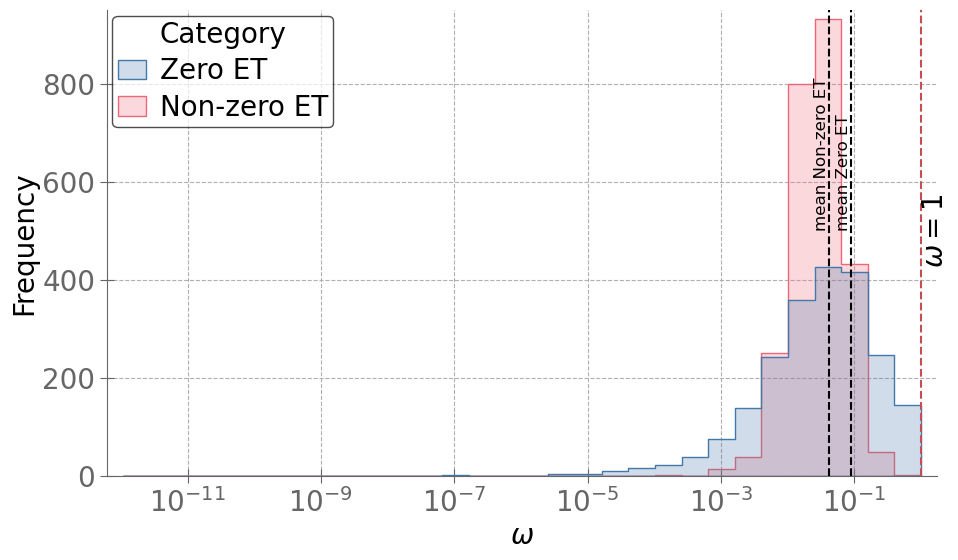

Mean Zero ET: 0.09001176852753763
Median Zero ET: 0.0240415229688661
Standard deviation Zero ET: 0.1691684952757647
-------------------------
Mean Non-zero ET: 0.04175384031633925
Median Non-zero ET: 0.0288132824029915
Standard deviation Non-zero ET: 0.04202012396887502
-------------------------
Tested against the null hypothesis that the test model is the same as the background model
Fraction of significant tests for fg: 0.006727344677483181
Observed variance ratio between zero ET and non-zero ET: 16.207809145461436


Running Variance Ratio Randomisation Test: 100%|██████████| 100000/100000 [00:44<00:00, 2268.95it/s]


Fraction of variance ratios greater than or equal to the observed variance ratio (p-value): 0.0


In [9]:

# Perform LRT
busted_df_compare_fg_all = perform_lrt(busted_dir, "output_fg", "fg")
# busted_df_compare_bg_all = perform_lrt(busted_dir, "output_bg", "bg")

# write out the df to a csv file
busted_df_compare_fg_all.to_csv(os.path.join(busted_dir, 'output_fg_compare_test_all.csv'), index=False)

# Plot histograms
busted_df_fg_compare_test_all_histplot_df = plot_histograms(busted_dir, "output_fg", "fg")
# plot_histograms(busted_dir, 'output_bg', 'bg')

# print how many and what fraction of the tests are significant
# print(f"Fraction of significant tests for fg: {busted_df_compare_fg_all['fg all|LRT significant'].sum() / busted_df_compare_fg_all.shape[0]}")
# print(f"Fraction of significant tests for bg: {busted_df_compare_bg_all['bg all|LRT significant'].sum() / busted_df_compare_bg_all.shape[0]}")


# # Perform LRT
# busted_df_compare_fg_all = perform_lrt(busted_dir, "output_fg", "fg")
# # busted_df_compare_bg_all = perform_lrt(busted_dir, "output_bg", "bg")
# # Plot histograms
# plot_histograms(busted_dir, 'output_fg', 'fg')
# # plot_histograms(busted_dir, "output_bg", "bg")

# # print how many and what fraction of the tests are significant
print("Tested against the null hypothesis that the test model is the same as the background model")
print(f"Fraction of significant tests for fg: {busted_df_compare_fg_all['fg all|LRT significant'].sum() / busted_df_compare_fg_all.shape[0]}")
# # print(
# #     f"Fraction of significant tests for bg: {busted_df_compare_bg_all['bg all|LRT significant'].sum() / busted_df_compare_bg_all.shape[0]}"
# # )

# Perform variance randomisation test
perform_variance_randomisation_test(busted_df_fg_compare_test_all_histplot_df)

,OG,fg|Unconstrained model|AIC-c,fg|Unconstrained model|Log Likelihood,fg|Unconstrained model|estimated parameters,fg|Unconstrained model|Background|0|omega,fg|Unconstrained model|Background|0|proportion,fg|Unconstrained model|Background|1|omega,fg|Unconstrained model|Background|1|proportion,fg|Unconstrained model|Test|0|omega,fg|Unconstrained model|Test|0|proportion,...,all|Unconstrained model|Test|1|mean omega,fg|Unconstrained model|Background|weighted mean omega,fg|Unconstrained model|Test|weighted mean omega,all|Unconstrained model|Test|weighted mean omega,nog_id,with_transfers,without_transfers,total,min_branch_set_size,min_branch_set_proportion
2,D4451,8632.427415,-4275.713250,40,0.059540,0.244445,0.000000,0.576114,0.000000,0.546884,...,0.000289,0.014554,0.053390,0.000289,D4451,7,5,12,5,0.416667
19,COG4267,17696.763115,-8810.319160,38,0.049920,0.231723,0.000185,0.574410,0.001399,0.440920,...,0.002310,0.011674,0.024095,0.002310,COG4267,6,4,10,4,0.400000
40,COG5509,2446.027561,-1184.720606,38,0.004030,0.808196,0.065777,0.191804,0.002947,0.108788,...,0.001341,0.015873,0.002312,0.003860,COG5509,6,4,10,4,0.400000
81,D972Z,3444.091815,-1686.473913,34,0.002074,0.584070,0.006116,0.291953,0.000055,0.466214,...,0.000000,0.002997,0.019723,0.005781,D972Z,3,3,6,3,0.500000
90,D8UD7,5554.183335,-2738.643798,38,0.000000,0.487540,0.037887,0.460600,0.000000,0.183316,...,0.000000,0.017451,0.013751,0.005946,D8UD7,6,4,10,4,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,COG5458,6441.839012,-3178.204258,42,0.031628,0.414634,0.000000,0.471154,0.004614,0.669053,...,0.004845,0.013114,0.079758,0.129793,COG5458,8,6,14,6,0.428571
2470,DA4PS,3211.328653,-1564.688717,40,0.125552,0.130744,0.125436,0.749163,0.001177,0.436095,...,0.142541,0.110387,0.082215,0.145566,DA4PS,7,5,12,5,0.416667
2485,D8WHH,6550.553192,-3236.627450,38,0.133164,0.912332,0.134526,0.005289,0.000000,0.457276,...,0.152553,0.122201,0.027872,0.153695,D8WHH,6,4,10,4,0.400000
2490,COG1813,10600.131188,-5255.996951,44,0.005622,0.270749,0.000000,0.729251,0.004291,0.249532,...,0.005908,0.001522,0.093143,0.159649,COG1813,9,7,16,7,0.437500


Total number of OGs in the background category (Zero ET): 157
Total number of OGs in the test category (Non-zero ET): 157
Total number of OGs in the all category: 157


,Weighted Mean Omega
0,0.014554
1,0.011674
2,0.015873
3,0.002997
4,0.017451
...,...
309,0.079758
310,0.082215
311,0.027872
312,0.093143


,Weighted Mean Omega,Category
0,0.014554,Zero ET
1,0.011674,Zero ET
2,0.015873,Zero ET
3,0.002997,Zero ET
4,0.017451,Zero ET
...,...,...
309,0.079758,Non-zero ET
310,0.082215,Non-zero ET
311,0.027872,Non-zero ET
312,0.093143,Non-zero ET


Category
Zero ET        157
Non-zero ET    157
Name: count, dtype: int64


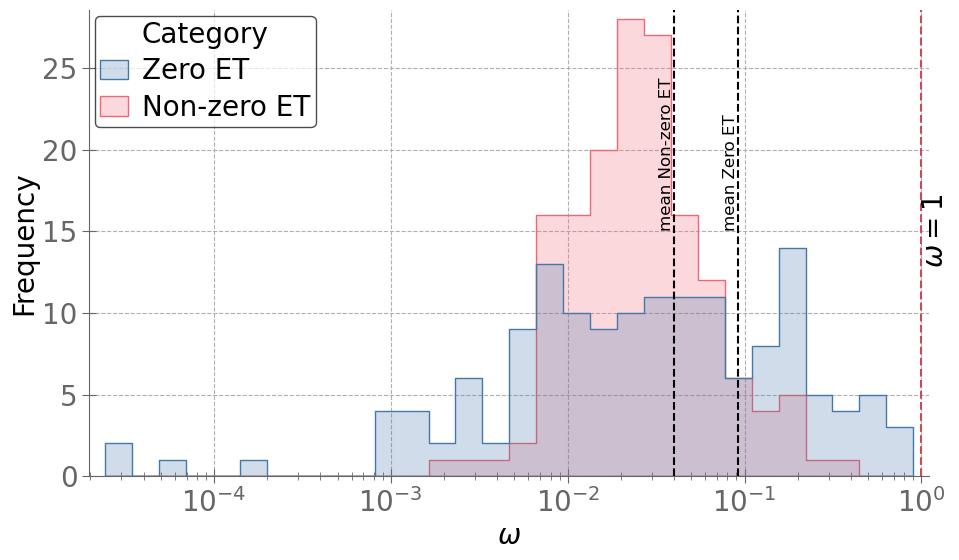

Mean Zero ET: 0.09196724235447933
Median Zero ET: 0.0268628523355969
Standard deviation Zero ET: 0.15407535061809008
-------------------------
Mean Non-zero ET: 0.03997429061690012
Median Non-zero ET: 0.025302437786658
Standard deviation Non-zero ET: 0.05027543247580709
-------------------------
Observed variance ratio between zero ET and non-zero ET: 9.391926801097716


Running Variance Ratio Randomisation Test: 100%|██████████| 100000/100000 [00:15<00:00, 6564.93it/s]


Fraction of variance ratios greater than or equal to the observed variance ratio (p-value): 0.0


In [10]:
# redo the histogram and variance randomisation test for the filtered df with min proportion >= 0.4
busted_df_compare_fg_all_histplot_df = plot_histograms(busted_dir, "output_fg", "fg", min_proportion=0.4)
perform_variance_randomisation_test(busted_df_compare_fg_all_histplot_df)

In [14]:
# read in the tsv file with branch counts
branch_counts_filepath = os.path.join(dnds_dir, 'branch_count.tsv')
branch_counts_df = pd.read_csv(branch_counts_filepath, sep='\t', header=0)

# read in the busted_df_compare_fg_all
busted_df_compare_fg_all = pd.read_csv(os.path.join(busted_dir, 'output_fg_compare_test_all.csv'), header=0)
# display(busted_df_compare_fg_all)

# merge the branch counts with the busted_df_compare_fg_all
busted_df_compare_fg_all = busted_df_compare_fg_all.merge(branch_counts_df, left_on='OG', right_on='nog_id', how='inner')

# min branch set size
busted_df_compare_fg_all['min_branch_set_size'] = busted_df_compare_fg_all[['with_transfers', 'without_transfers']].min(axis=1)

# min branch set proportion
busted_df_compare_fg_all['min_branch_set_proportion'] = busted_df_compare_fg_all['min_branch_set_size'] / busted_df_compare_fg_all['total']


In [15]:
# perform a paired t-test between the omega values of the same set of OGs in the background and test categories, and report along with mean and SD
from scipy.stats import ttest_rel
print("Background is the branch-set with zero ecotype gains, and test is the branch-set with non-zero ecotype gains")
print("-------------------------------------------------\n")

# background and test comparison
print("Background and test comparison")
print(ttest_rel(busted_df_compare_fg_all['fg|Unconstrained model|Background|weighted mean omega'], busted_df_compare_fg_all['fg|Unconstrained model|Test|weighted mean omega']))
print(f"Mean omega background: {busted_df_compare_fg_all['fg|Unconstrained model|Background|weighted mean omega'].mean()} +/- {busted_df_compare_fg_all['fg|Unconstrained model|Background|weighted mean omega'].std()}")
print(f"Mean omega test: {busted_df_compare_fg_all['fg|Unconstrained model|Test|weighted mean omega'].mean()} +/- {busted_df_compare_fg_all['fg|Unconstrained model|Test|weighted mean omega'].std()}")
print("-------------------------------------------------\n")


# test and all comparison
print("Test and all comparison")
print(ttest_rel(busted_df_compare_fg_all['fg|Unconstrained model|Test|weighted mean omega'], busted_df_compare_fg_all['all|Unconstrained model|Test|weighted mean omega']))
print(f"Mean omega test: {busted_df_compare_fg_all['fg|Unconstrained model|Test|weighted mean omega'].mean()} +/- {busted_df_compare_fg_all['fg|Unconstrained model|Test|weighted mean omega'].std()}")
print(f"Mean omega all: {busted_df_compare_fg_all['all|Unconstrained model|Test|weighted mean omega'].mean()} +/- {busted_df_compare_fg_all['all|Unconstrained model|Test|weighted mean omega'].std()}")
print("-------------------------------------------------\n")

# background and all comparison
print("Background and all comparison")
print(ttest_rel(busted_df_compare_fg_all['fg|Unconstrained model|Background|weighted mean omega'], busted_df_compare_fg_all['all|Unconstrained model|Test|weighted mean omega']))
print(f"Mean omega background: {busted_df_compare_fg_all['fg|Unconstrained model|Background|weighted mean omega'].mean()} +/- {busted_df_compare_fg_all['fg|Unconstrained model|Background|weighted mean omega'].std()}")
print(f"Mean omega all: {busted_df_compare_fg_all['all|Unconstrained model|Test|weighted mean omega'].mean()} +/- {busted_df_compare_fg_all['all|Unconstrained model|Test|weighted mean omega'].std()}")
print("-------------------------------------------------\n")

Background is the branch-set with zero ecotype gains, and test is the branch-set with non-zero ecotype gains
-------------------------------------------------

Background and test comparison
TtestResult(statistic=np.float64(13.875912015481846), pvalue=np.float64(3.023189910872782e-42), df=np.int64(2526))
Mean omega background: 0.09001176852753763 +/- 0.1691684952757647
Mean omega test: 0.04175384031633925 +/- 0.04202012396887502
-------------------------------------------------

Test and all comparison
TtestResult(statistic=np.float64(1.0899052653069574), pvalue=np.float64(0.2758588375790183), df=np.int64(2526))
Mean omega test: 0.04175384031633925 +/- 0.04202012396887502
Mean omega all: 0.04095828880900997 +/- 0.038269785797994095
-------------------------------------------------

Background and all comparison
TtestResult(statistic=np.float64(14.494098736064336), pvalue=np.float64(8.627506286102247e-46), df=np.int64(2526))
Mean omega background: 0.09001176852753763 +/- 0.1691684952757

In [16]:
# redo the paired t-test for the filtered df with min proportion >= 0.4 to see if the results are consistent even if the branch sets are more balanced in sizes
print("Background is the branch-set with zero ecotype gains, and test is the branch-set with non-zero ecotype gains")
print("-------------------------------------------------\n")
print("Background and test comparison")
filtered_df_0_4 = busted_df_compare_fg_all[busted_df_compare_fg_all['min_branch_set_proportion'] >= 0.4]
print(ttest_rel(filtered_df_0_4['fg|Unconstrained model|Background|weighted mean omega'], filtered_df_0_4['fg|Unconstrained model|Test|weighted mean omega']))
print(f"Mean omega background: {filtered_df_0_4['fg|Unconstrained model|Background|weighted mean omega'].mean()} +/- {filtered_df_0_4['fg|Unconstrained model|Background|weighted mean omega'].std()}")
print(f"Mean omega test: {filtered_df_0_4['fg|Unconstrained model|Test|weighted mean omega'].mean()} +/- {filtered_df_0_4['fg|Unconstrained model|Test|weighted mean omega'].std()}")

Background is the branch-set with zero ecotype gains, and test is the branch-set with non-zero ecotype gains
-------------------------------------------------

Background and test comparison
TtestResult(statistic=np.float64(3.9759251599866325), pvalue=np.float64(0.00010696836654160888), df=np.int64(156))
Mean omega background: 0.09196724235447933 +/- 0.15407535061809008
Mean omega test: 0.03997429061690012 +/- 0.05027543247580709
